## Sagnac Frequency - Backscatter Correction - Temperature

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream
from scipy.signal import hilbert

# from functions.get_fft import __get_fft
# from functions.multitaper_psd import __multitaper_psd
# from functions.welch_psd import __welch_psd
from functions.compute_cwt import __compute_cwt
from functions.get_stream import __get_stream

from andbro__read_sds import __read_sds
# from andbro__readYaml import __readYaml

In [2]:
from functions.reduce import __reduce
from functions.multitaper_coherence import __multitaper_coherence
from functions.cross_correlation_function_windows import __cross_correlation_function_windows
from functions.cross_correlation_windows import __cross_correlation_windows
from functions.load_backscatter_data import __load_backscatter_data
from functions.cc_lag_matrix import __cc_lag_matrix
from functions.backscatter_correction import __backscatter_correction

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'

## Configurations

In [4]:
config = {}

config['ring'] = "V"

config['seed'] = f"BW.DROMY..FJ{config['ring']}"

config['path_to_sds'] = archive_path+"romy_archive/"

case = 10
config['tbeg'] = UTCDateTime("2024-07-16 00:00")
config['tend'] = UTCDateTime("2024-07-19 12:00")
flim1, flim2 = 447.733, 447.746

# path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

## Configurations

In [5]:
bs = __load_backscatter_data(config['tbeg'], config['tend']+86400, config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

bs = bs[(bs.time1 >= config['tbeg']) & (bs.time2 <= config['tend'])]

In [6]:
bs

,index,time1,time2,fj_fs,fj_ac,fj_dc,fj_ph,fj_st,fj_phw,f1_fs,...,f2_fs,f2_ac,f2_dc,f2_ph,f2_st,f2_phw,w_s,bscorrection,term,time_sec
0,0,2024-07-16T00:00:00.000000Z,2024-07-16T00:01:00.000000Z,447.737750,0.106626,0.128816,2.977012,0.001793,2.977012,447.786648,...,447.753725,0.000308,0.207244,-2.366369,0.149945,-2.366369,447.737471,0.000279,0.999999,60.0
1,1,2024-07-16T00:01:00.000000Z,2024-07-16T00:02:00.000000Z,447.737901,0.125727,0.128801,4.214920,0.002206,-2.068265,447.775317,...,447.751710,0.000396,0.207239,-1.027440,0.120739,-1.027440,447.737460,0.000441,0.999999,120.0
2,2,2024-07-16T00:02:00.000000Z,2024-07-16T00:03:00.000000Z,447.737848,0.127883,0.128806,5.887834,0.001527,-0.395351,447.758645,...,447.745513,0.000408,0.207229,0.769266,0.105248,0.769266,447.737415,0.000433,0.999999,180.0
3,3,2024-07-16T00:03:00.000000Z,2024-07-16T00:04:00.000000Z,447.737970,0.130347,0.128810,7.607100,0.001506,1.323915,447.765704,...,447.748316,0.000407,0.207220,2.550464,0.122567,2.550464,447.737554,0.000416,0.999999,240.0
4,4,2024-07-16T00:04:00.000000Z,2024-07-16T00:05:00.000000Z,447.737822,0.128327,0.128812,9.328280,0.001498,3.045094,447.762344,...,447.746868,0.000413,0.207224,4.316201,0.105126,-1.966984,447.737403,0.000419,0.999999,300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5035,55,2024-07-19T11:55:00.000000Z,2024-07-19T11:56:00.000000Z,447.740647,0.163594,0.131217,151.561915,0.004227,0.765468,447.745528,...,447.742246,0.000641,0.208697,153.727282,0.067646,2.930835,447.739651,0.000996,0.999998,302160.0
5036,56,2024-07-19T11:56:00.000000Z,2024-07-19T11:57:00.000000Z,447.740468,0.163406,0.131203,154.263042,0.004248,-2.816591,447.746028,...,447.742695,0.000640,0.208691,156.426845,0.061550,-0.652788,447.739460,0.001007,0.999998,302220.0
5037,57,2024-07-19T11:57:00.000000Z,2024-07-19T11:58:00.000000Z,447.740493,0.163444,0.131176,156.955219,0.004562,-0.124414,447.744675,...,447.740301,0.000640,0.208687,159.144635,0.058856,2.065003,447.739482,0.001010,0.999998,302280.0
5038,58,2024-07-19T11:58:00.000000Z,2024-07-19T11:59:00.000000Z,447.740415,0.163645,0.131162,159.663184,0.004459,2.583551,447.745350,...,447.742561,0.000639,0.208682,161.884692,0.060280,-1.478126,447.739407,0.001008,0.999998,302340.0


In [7]:
# unwrap phases as one time series
# bs['fj_ph'] = np.unwrap(bs.fj_ph)
# bs['f1_ph'] = np.unwrap(bs.f1_ph)
# bs['f2_ph'] = np.unwrap(bs.f2_ph)

# use complete unwrapped phases
bs['fj_ph'] = np.unwrap(bs.fj_phw)
bs['f1_ph'] = np.unwrap(bs.f1_phw)
bs['f2_ph'] = np.unwrap(bs.f2_phw)

# fractional beat modulations
m01 = bs.f1_ac / bs.f1_dc
m02 = bs.f2_ac / bs.f2_dc

# phase difference
ph1 = bs.f1_ph
ph2 = bs.f2_ph
phase0 = ph2 - ph1

# beat signal observed
w_obs = bs.fj_fs

# compute backscatter corrected signal
# bs['fj_bs'] = __backscatter_correction(m01, m02, phase0, w_obs, np.median(bs.fj_fs), cm_filter_factor=1.033)
bs['fj_bs'] = __backscatter_correction(m01, m02, phase0, w_obs, np.median(bs.fj_fs), cm_filter_factor=2.5)


<Figure size 1500x500 with 0 Axes>

(447.733, 447.746)

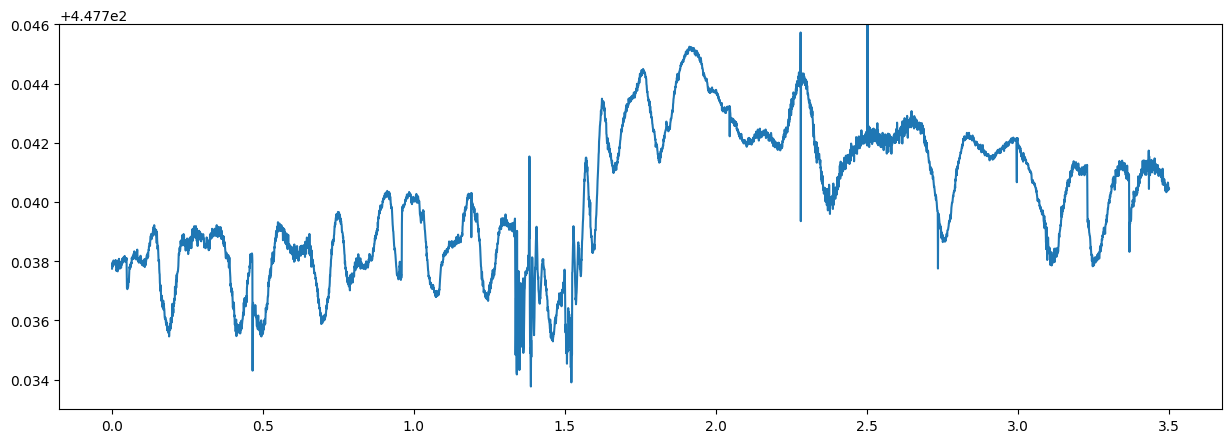

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(bs.time_sec/86400, bs.fj_fs)
plt.ylim(flim1, flim2)

### Cut corrupt data periods

In [9]:
bs['fj_fs'] = np.where((bs.fj_fs > flim2), np.nan, bs.fj_fs)
bs['fj_fs'] = np.where((bs.fj_fs < flim1), np.nan, bs.fj_fs)

bs['fj_bs'] = np.where((bs.fj_bs > flim2), np.nan, bs.fj_bs)
bs['fj_bs'] = np.where((bs.fj_bs < flim1), np.nan, bs.fj_bs)

In [10]:
def __time_spans_to_nan(bs, time_spans):

    for t1, t2 in time_spans:
        bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
        bs['fj_bs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_bs)


time_spans = [("2024-06-20T12:00", "2024-06-21T12:00"),
              ("2024-06-24T12:00", "2024-06-26T06:00")
             ]

__time_spans_to_nan(bs, time_spans)

In [11]:
from functions.load_mlti import __load_mlti
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

mlti = __load_mlti(config['tbeg'], config['tend'], config['ring'], archive_path)

mlti_t1, mlti_t2 = __get_mlti_intervals(mlti.time_utc)

bs = __mlti_intervals_to_NaN(bs, "fj_fs", "time1", mlti_t1, mlti_t2, t_offset_sec=180)
bs = __mlti_intervals_to_NaN(bs, "fj_bs", "time1", mlti_t1, mlti_t2, t_offset_sec=180)

In [12]:
from functions.interpolate_nan import __interpolate_nan

bs['fj_fs_inter'] = __interpolate_nan(np.array(bs.fj_fs_nan))
bs['fj_bs_inter'] = __interpolate_nan(np.array(bs.fj_bs_nan))

In [13]:
from functions.smoothing import __smooth

n_minutes = 600

bs['fj_fs_smooth'] = __smooth(bs.fj_fs_inter, n_minutes)
bs['fj_bs_smooth'] = __smooth(bs.fj_bs_inter, n_minutes)

/tmp/ipykernel_2583146/3733657830.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tcklbls)


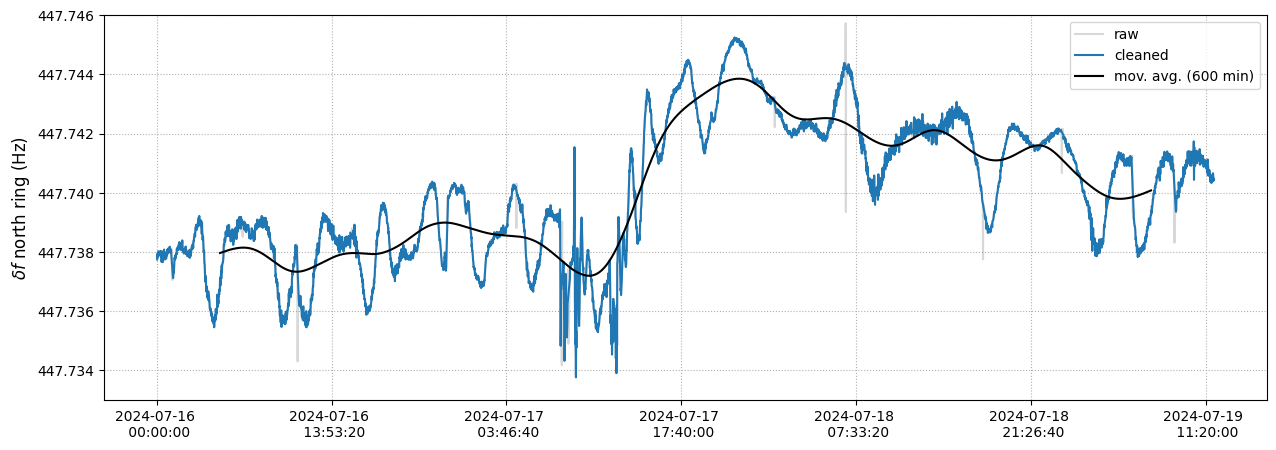

In [14]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1

    ax.plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax.plot(bs.time_sec*time_scaling, bs.fj_fs_inter, color="tab:blue", label="cleaned")
    ax.plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax.set_ylim(flim1, flim2)
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)


    ## add dates to x-axis
    ref_date = str(bs.time1.iloc[0])[:10]
    tcks = ax.get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax.set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_cleaned.png", format="png", dpi=150, bbox_inches='tight')


In [15]:
ttt = bs.time_sec
arr = bs.fj_fs_inter
dt  = 60 # seconds

# out = __compute_cwt(ttt, arr, dt, tscale="hour", datalabel="$\Delta f (Hz)",
#                     log=False, period=True, fmax=None, plot=True)

# out['fig'].savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_CWT_1.png", format="png", dpi=200, bbox_inches='tight')


### Load maintenenace log

In [16]:
from functions.load_lxx import __load_lxx
from functions.get_lxx_intervals import __get_lxx_intervals

lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)
lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

### Load Temperature Data

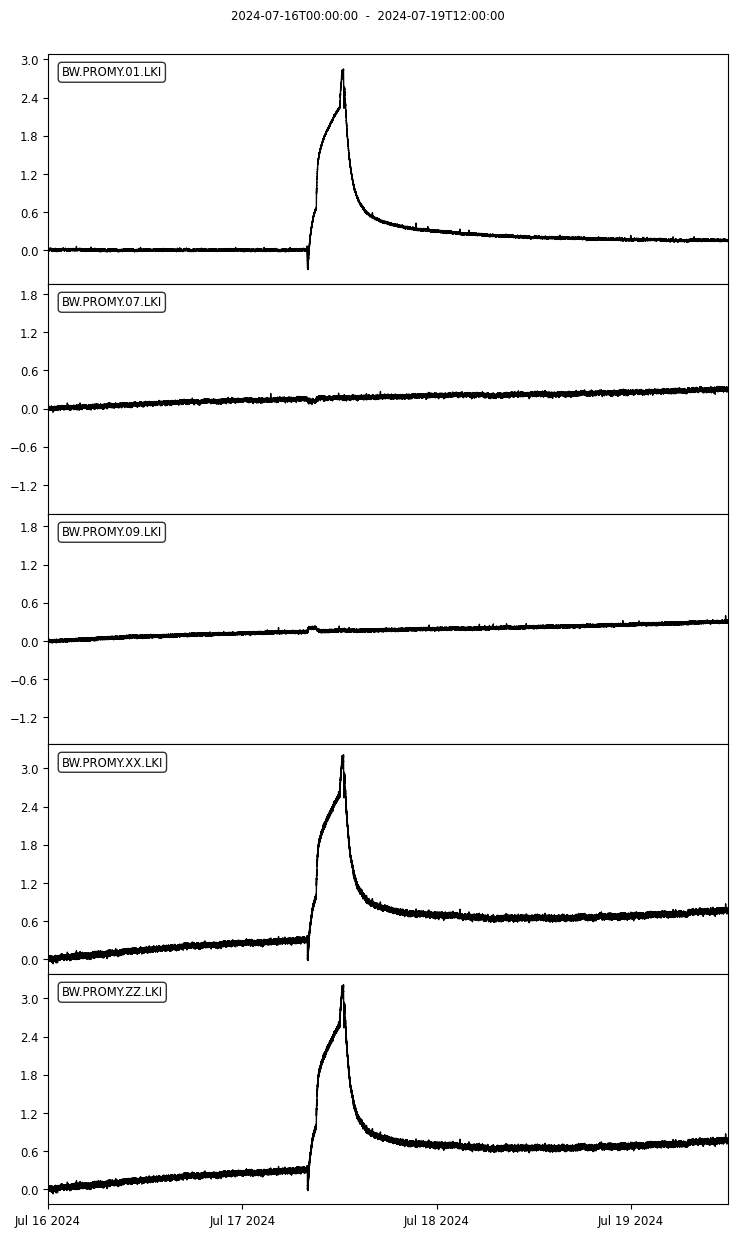

In [17]:
# ps = __read_sds(archive_path+"temp_archive/", "BW.PROMY.03.LKI", config['tbeg'], config['tend'])

ps1 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.01.LKI", config['tbeg'], config['tend'])
ps7 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.07.LKI", config['tbeg'], config['tend'])
ps9 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.09.LKI", config['tbeg'], config['tend'])

ps_sum = ps1[0].data+ps7[0].data+ps9[0].data
psx = __get_stream(ps_sum, ps1[0].stats.delta, "BW.PROMY.XX.LKI", ps1[0].stats.starttime)
psz = __get_stream(ps_sum, ps1[0].stats.delta, "BW.PROMY.ZZ.LKI", ps1[0].stats.starttime)

ps = Stream()
ps += ps1
ps += ps7
ps += ps9
ps += psx
ps += psz

ps = ps.merge()

for tr in ps:
    tr.data = __reduce(tr.data, 10)

# for tr in ps:
#     # tr.data = __smooth(tr.data, 10)
#     tr.data = __interpolate_nan(tr.data)
#     # tr.data = np.gradient(tr.data)

ps.plot();

In [18]:
from functions.load_sagnac_beat_data import __load_sagnac_beat_data

# path to Sagnac Beat data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

beatU = __load_sagnac_beat_data(config['tbeg'], config['tend'], "U", config['path_to_autodata'])


mltiU = __load_mlti(config['tbeg'], config['tend'], "U", archive_path)
mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)
beatU = __mlti_intervals_to_NaN(beatU, "fj", "times_utc", mltiU_t1, mltiU_t2, t_offset_sec=180)

beatU['fj_inter'] = __interpolate_nan(np.array(beatU.fj_nan))

beatU['fj_smooth'] = __smooth(beatU.fj_inter, 6*60)

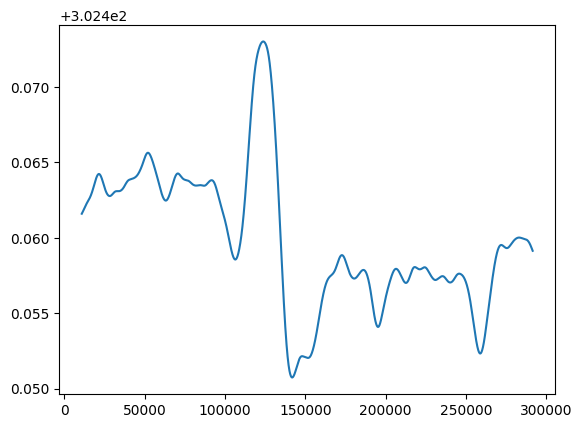

In [19]:
plt.plot(beatU.times_utc_sec, beatU.fj_smooth)

447.7376886911079


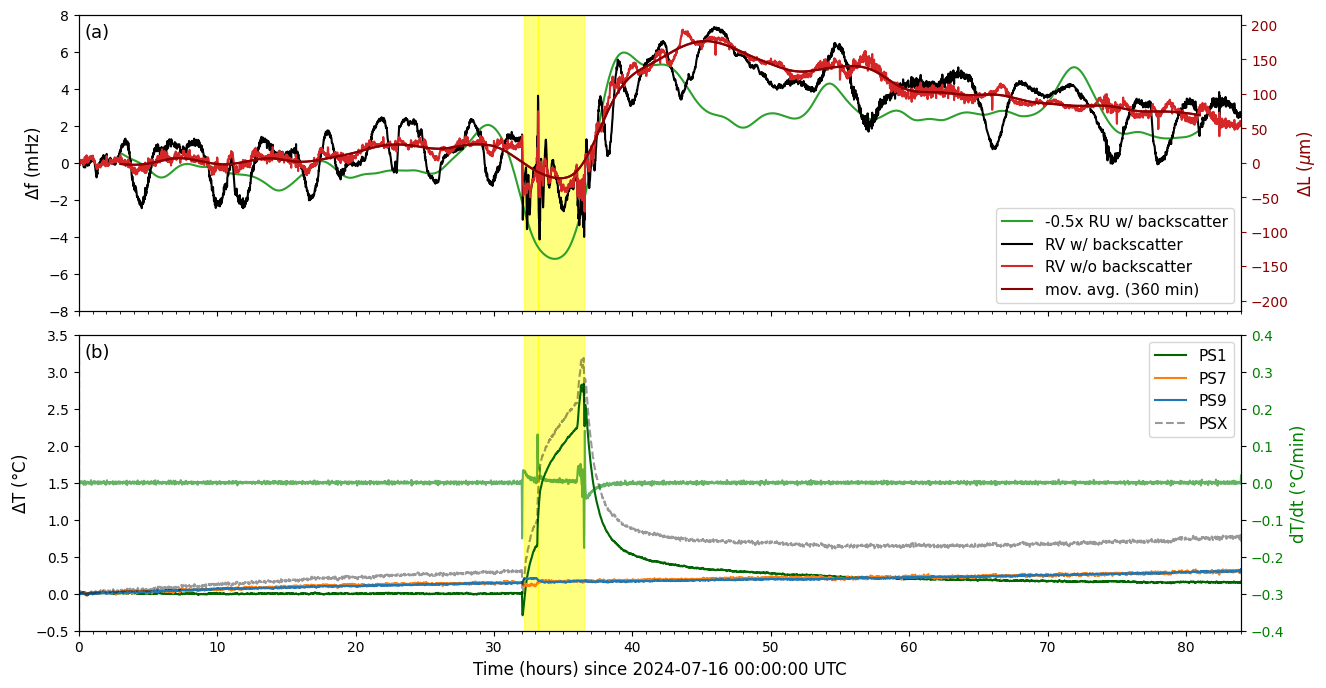

In [102]:
def __makeplot(key1, key2):

    import mpl_axes_aligner
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    factor = -0.5
    df0 = __smooth(__reduce(beatU.fj_inter, 200), 6*60) * factor
    df0_time = beatU.times_utc_sec

    df1 = __reduce(bs[key1], 10)
    df2 = __reduce(bs[key2], 10)

    nmin = 6*60
    df3 = __smooth(__reduce(bs[key2], 10), nmin)

    reftime = bs.time1.iloc[0]

    f0 = np.nanmean(bs[key2][:10])
    print(f0)

    dL = 12.0 * df3 / f0

    # manual offest to align zeros
    # dL += 57.1

    dT = np.gradient(ps.select(location="01")[0].data) / ps.select(location="01")[0].stats.delta

    # ___________________________________________

    Nrow, Ncol = 2, 1

    font = 12

    tscale, tunit = 1/3600, "hours"

    fscale, funit = 1e3, "mHz"

    lscale, lunit = 1e6, r"$\mu$m"

    dTscale, dTunit = 60, r"°C/min"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.08)

    ax[0].plot(df0_time*tscale, df0*fscale, color="tab:green", label=f"{factor}x RU w/ backscatter")

    ax[0].plot(bs.time_sec*tscale, df1*fscale, color="black", label=f"RV w/ backscatter")
    ax[0].plot(bs.time_sec*tscale, df2*fscale, color="tab:red", label=f"RV w/o backscatter")
    ax[0].plot(bs.time_sec*tscale, df3*fscale, color="darkred", label=f"mov. avg. ({nmin} min)")

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylim(-8, 8)

    ax000 = ax[0].twinx()
    ax000.plot(bs.time_sec*tscale, dL*lscale, color="darkred")
    ax000.set_ylim(ax000.get_yticks()[0], 215)
    ax000.set_ylabel(f"$\Delta$L ({lunit})", fontsize=font, color="darkred")
    ax000.tick_params(axis='y', colors="darkred")
    mpl_axes_aligner.align.yaxes(ax[0], 0, ax000, 0, 0.5)
    # ax000.set_yticks(np.linspace(ax000.get_yticks()[0], ax000.get_yticks()[-1], len(ax[0].get_yticks())))

    ax[1].plot(ps.select(location="01")[0].times(reftime=reftime)*tscale, ps.select(location="01")[0].data,
               color="darkgreen", label="PS1")
    ax[1].plot(ps.select(location="07")[0].times(reftime=reftime)*tscale, ps.select(location="07")[0].data,
               color="tab:orange", label=f"PS7")
    ax[1].plot(ps.select(location="09")[0].times(reftime=reftime)*tscale, ps.select(location="09")[0].data,
               color="tab:blue", label=f"PS9")
    ax[1].plot(ps.select(location="XX")[0].times(reftime=reftime)*tscale, ps.select(location="XX")[0].data,
               color="k", label=f"PSX", ls="--", alpha=0.4)

    ax111 = ax[1].twinx()
    ax111.plot(ps.select(location="01")[0].times(reftime=reftime)*tscale, dT*dTscale,
               color="green", label=f"", alpha=0.6)
    ax111.set_ylabel(f"dT/dt ({dTunit})", fontsize=font, color="green")
    ax111.set_ylim(-0.4, 0.4)
    [t.set_color('green') for t in ax111.yaxis.get_ticklabels()]

    # for _n in range(Nrow):
        # ax[_n].grid(which="both", ls=":", zorder=0)
        # ax[_n].legend(loc=1, fontsize=font-1)

    ax[0].set_xlim(0, max(bs.time_sec)*tscale)

    ax[0].legend(loc=4, fontsize=font-1)
    ax[1].legend(loc=1, fontsize=font-1)

    ax[0].set_ylabel(f"$\Delta$f ({funit})", fontsize=font)
    ax[1].set_xlabel(f"Time ({tunit}) since {config['tbeg'].date} {config['tbeg'].time} UTC", fontsize=font)
    ax[1].set_ylabel("$\Delta$T (°C)", fontsize=font)

    ax[1].axvline(1/(12*3600), ls="--", color="grey", zorder=0)
    ax[1].axvline(1/(24*3600), ls="--", color="grey", zorder=0)

    # add dates to x-axis
    # ref_date = str(bs.time1.iloc[0])[:10]
    # tcks = ax[1].get_xticks()
    # tcklbls = [UTCDateTime(UTCDateTime(ref_date)+t).date for t in tcks]
    # ax[1].set_xticklabels(tcklbls)

    # add maintenance intervals
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = (lx1-UTCDateTime(reftime))*tscale
        lx2_sec = (lx2-UTCDateTime(reftime))*tscale
        ax[0].fill_betweenx([-10, 10], lx1_sec, lx2_sec, color="yellow", alpha=0.5)
        ax[1].fill_betweenx([-10, 10], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    # add manual (not triggered in shaft 03 automatically)
    tstart = (lxx_t1[0]-UTCDateTime(reftime))*tscale
    ax[0].fill_betweenx([-10, 10], tstart-1, tstart, color="yellow", alpha=0.5)
    ax[1].fill_betweenx([-10, 10], tstart-1, tstart, color="yellow", alpha=0.5)

    # ax[0].set_ylim(-8, 8)
    ax[1].set_ylim(-0.5, 3.5)

    # adjust ticks
    ax[0].xaxis.set_major_locator(MultipleLocator(10))
    ax[0].xaxis.set_minor_locator(MultipleLocator(1))

    # set sublabels
    for _k, ll in enumerate(['(a)', '(b)']):
        ax[_k].text(0.005, 0.97, ll, ha="left", va="top", transform=ax[_k].transAxes, fontsize=font+1)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot("fj_fs_inter", "fj_bs_inter");

fig.savefig(config['path_to_figs']+f"SF_BS_RV_temperature_Case{case}.png", format="png", dpi=150, bbox_inches='tight')


5 Trace(s) in Stream:
BW.PROMY.01.LKI | 2024-07-16T00:00:00.000000Z - 2024-07-19T11:59:00.000000Z | 60.0 s, 5040 samples
BW.PROMY.07.LKI | 2024-07-16T00:00:00.000000Z - 2024-07-19T11:59:00.000000Z | 60.0 s, 5040 samples
BW.PROMY.09.LKI | 2024-07-16T00:00:00.000000Z - 2024-07-19T11:59:00.000000Z | 60.0 s, 5040 samples
BW.PROMY.XX.LKI | 2024-07-16T00:00:00.000000Z - 2024-07-19T11:59:00.000000Z | 60.0 s, 5040 samples
BW.PROMY.ZZ.LKI | 2024-07-16T00:00:00.000000Z - 2024-07-19T11:59:00.000000Z | 60.0 s, 5040 samples

1 Trace(s) in Stream:
BW.ROMY..LJV | 2024-07-16T00:00:00.000000Z - 2024-07-19T11:59:00.000000Z | 60.0 s, 5040 samples


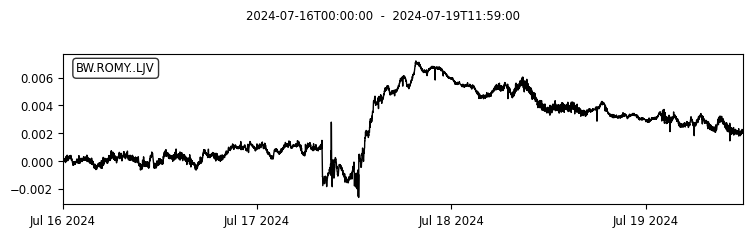

In [22]:
# arr = np.array(bs.fj_bs_smooth)
arr = __reduce(np.array(bs.fj_bs_inter), 10)

rst = __get_stream(arr, 60, f"BW.ROMY..LJ{config['ring']}", bs.time1.iloc[0])

print(rst)

rst.plot(equal_scale=False);

In [23]:
stt = Stream()

stt += ps.resample(1/60).copy()
stt += rst.copy()

stt = stt.detrend("linear")
stt = stt.taper(0.05, type="cosine")
stt = stt.filter("lowpass", freq=1/(12*3600), corners=4, zerophase=True)

for tr in stt:
    if "K" in tr.stats.channel:
        if "ZZ" in tr.stats.location:
            # tr = tr.integrate()
            tr = tr.differentiate()

for tr in stt:
    if "V" in tr.stats.channel:
        tr = tr.differentiate()

# stt.trim(config['tbeg']+1.7*86400, config['tend'])
stt.trim(config['tbeg']+1.5*86400, config['tbeg']+1.6*86400)

6 Trace(s) in Stream:
BW.PROMY.01.LKI | 2024-07-17T12:00:00.000000Z - 2024-07-17T14:24:00.000000Z | 60.0 s, 145 samples
BW.PROMY.07.LKI | 2024-07-17T12:00:00.000000Z - 2024-07-17T14:24:00.000000Z | 60.0 s, 145 samples
BW.PROMY.09.LKI | 2024-07-17T12:00:00.000000Z - 2024-07-17T14:24:00.000000Z | 60.0 s, 145 samples
BW.PROMY.XX.LKI | 2024-07-17T12:00:00.000000Z - 2024-07-17T14:24:00.000000Z | 60.0 s, 145 samples
BW.PROMY.ZZ.LKI | 2024-07-17T12:00:00.000000Z - 2024-07-17T14:24:00.000000Z | 60.0 s, 145 samples
BW.ROMY..LJV    | 2024-07-17T12:00:00.000000Z - 2024-07-17T14:24:00.000000Z | 60.0 s, 145 samples

/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


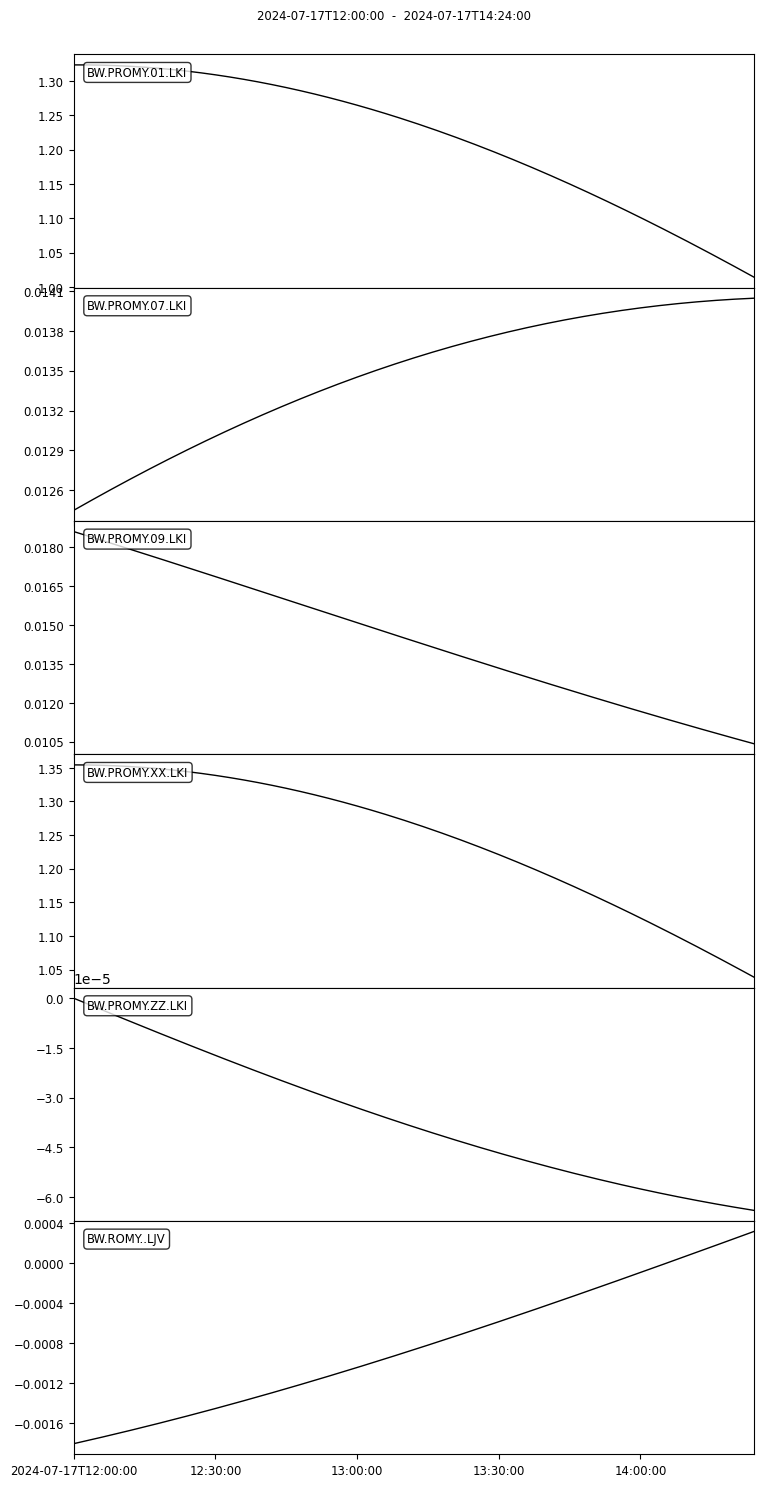

In [661]:
stt.plot(equal_scale=False);

In [662]:
def __find_model(ddf, _features, target="fj_fs", reg="ransac"):

    from sklearn import linear_model
    from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor

    _df = ddf.copy()

    # remove time and target
    try:
        _features.remove(target)
    except:
        pass
    try:
        _features.remove("time")
    except:
        pass

    print(_features)

    # define x data
    X = _df[_features].values.reshape(-1, len(_features))

    # define y data
    y = _df[target].values

    # multi linear regression

    # using OLS
    if reg.lower() == "ols":
        ols = linear_model.LinearRegression()
        model = ols.fit(X, y)

        print("R2:", model.score(X, y))
        print("X0:",  model.intercept_)
        print("Coef: ",  model.coef_)
        for _f, _c in zip(_features, model.coef_):
            print(f"{_f} : {_c}")

    elif reg.lower() == "ransac":
        model = RANSACRegressor(random_state=1).fit(X, y)
        print("R2:", model.score(X, y))
        print("IC: ", model.estimator_.intercept_)
        print("Coef: ",  model.estimator_.coef_)
        for _f, _c in zip(_features, model.estimator_.coef_):
            print(f"{_f} : {_c}")

    # using TheilSen
    elif reg.lower() == "theilsen":
        model = TheilSenRegressor().fit(X, y)

        print("R2:", model.score(X, y))
        print("X0:",  model.intercept_)
        print("Coef: ",  model.coef_)
        for _f, _c in zip(_features, model.coef_):
            print(f"{_f} : {_c}")

    # prediction
    model_predict = []

    for o, row in _df[_features].iterrows():

        x_pred = []
        for feat in _features:
            x_pred.append(row[feat])

        x_pred = np.array(x_pred)
        x_pred = x_pred.reshape(-1, len(_features))

        model_predict.append(model.predict(x_pred))

    out = {}
    out['model'] = model
    out['r2'] = model.score(X, y)
    out['tp'] = _df.time
    out['dp'] = model_predict

    try:
        out['slope'] = float(model.estimator_.coef_)
        out['inter'] = float(model.estimator_.intercept_)
    except:
        pass
    try:
        out['slope'] = float(model.coef_)
        out['inter'] = float(model.intercept_)
    except:
        pass

    # plt.plot(_df.time, model_predict)
    # plt.plot(_df.time, _df[target].values)

    return out

['TT']
R2: 0.8969353679149294
X0: 0.008901774696696934
Coef:  [-0.00773318]
TT : -0.007733175358830335
N: -0.008 | E: -0.008


/tmp/ipykernel_978418/253635200.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out['slope'] = float(model.coef_)


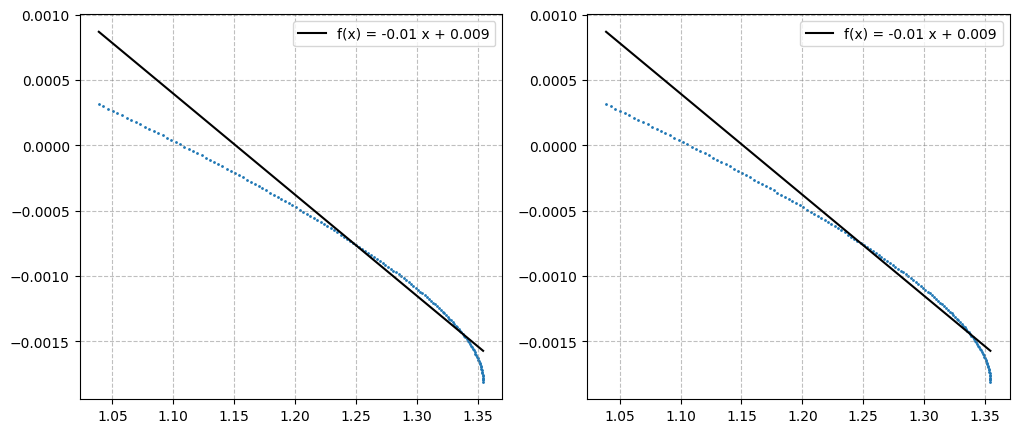

In [664]:
def __makeplot():

    import matplotlib.pyplot as plt

    # tilt_scale, tilt_unit = 1e9, f"nrad"

    tscale = 1/86400

    times = stt.select(channel="*V")[0].times()*tscale

    VV = stt.select(station="ROMY", channel="*V")[0].data
    TT = stt.select(location="XX", channel="*KI")[0].data

    # find scaling for Pressure and Tilt
    # Nx = len(PP)
    # PNm, PNy = __compute_orthogonal_distance_regression(PP[:Nx], RN[:Nx])
    # PEm, PEy = __compute_orthogonal_distance_regression(PP[:Nx], RE[:Nx])

    # scale pressue to tilt
    # PN = PP * PNm
    # PE = PP * PEm

    # ransac regression
    _df = DataFrame()
    _df['time'] = times
    _df['VV'] = VV
    _df['TT'] = TT

    out = __find_model(_df, ['TT'], target='VV', reg="theilsen")
    Tm, Ty = out['slope'], out['inter']

    print(f"N: {Tm:.3f} | E: {Tm:.3f}")

    # __________________________________________________________

    Nrow, Ncol = 1, 2

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0].scatter(TT, VV, s=1)
    ax[0].plot(TT, TT*Tm+Ty, "k", label=f"f(x) = {Tm:.2f} x + {Ty:.3f}")

    ax[1].scatter(TT, VV, s=1)
    ax[1].plot(TT, TT*Tm+Ty, "k", label=f"f(x) = {Tm:.2f} x + {Ty:.3f}")

    for i in range(Ncol):
        ax[i].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        # ax[i].set_xlim(0, maxs[i])
        # ax[i].set_ylim(0, maxs[i])
        ax[i].legend()

#     ax[0].set_ylabel("residual N-S Tilt (nrad)", fontsize=font)
#     ax[1].set_ylabel("residual E-W Tilt (nrad)", fontsize=font)

#     ax[0].set_xlabel("relative Pressure (hPa)", fontsize=font)
#     ax[1].set_xlabel("relative Pressure (hPa)", fontsize=font)

    plt.show();
    return fig

fig = __makeplot();


Nshift:  0 Tshift:  0.0 CC:  0.9786528482506518
Nshift:  0 Tshift:  0.0 CC:  -0.9400201275104343


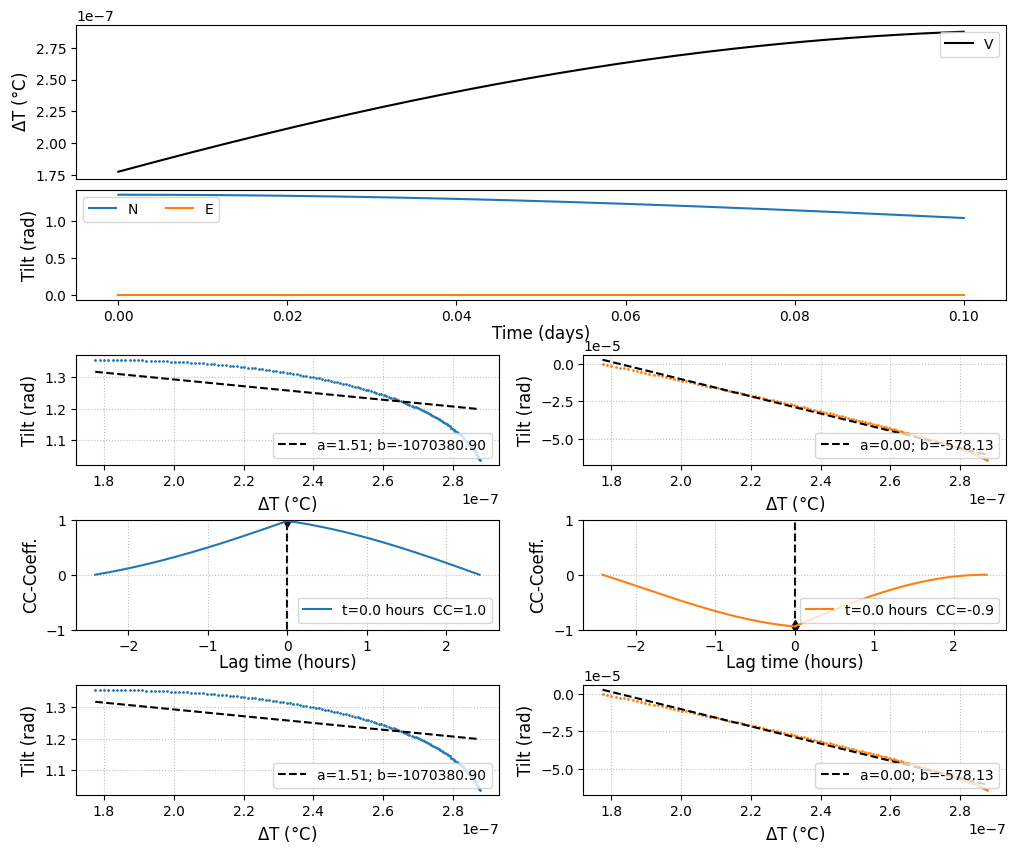

In [658]:
def __compare_tilt_pressure(st0):

    from obspy.signal.cross_correlation import correlate, xcorr_max
    from numpy import nan_to_num, arange, array, linspace, imag, roll
    from matplotlib.gridspec import GridSpec
    from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
    from functions.smoothing import __smooth
    from scipy.signal import hilbert

    _tlp = st0.copy()

    dt = _tlp[0].stats.delta

    yscale, yunit = 1, r""

    tscale, tunit = 1/86400, "days"

    times = _tlp[0].times()*tscale

    ch = "V"

    arr0 = nan_to_num(_tlp.select(component=ch)[0].data, 0)
    arr1 = nan_to_num(_tlp.select(location="XX")[0].data, 0)
    arr2 = nan_to_num(_tlp.select(location="ZZ")[0].data, 0)


    Nshift = len(arr0)

    ccf1 = correlate(arr0, arr1, shift=Nshift, demean=False, normalize='naive', method='fft')
    ccf2 = correlate(arr0, arr2, shift=Nshift, demean=False, normalize='naive', method='fft')

    cclags = arange(-Nshift, Nshift+1) * dt

    shift1, value1 = xcorr_max(ccf1)
    shift2, value2 = xcorr_max(ccf2)

    arr1_shifted = roll(arr1, shift1)
    arr2_shifted = roll(arr2, shift2)

    print("Nshift: ", shift1, "Tshift: ", shift1*dt, "CC: ", value1)
    print("Nshift: ", shift2, "Tshift: ", shift2*dt, "CC: ", value2)


    b1, a1 = __compute_orthogonal_distance_regression(arr0, arr1, xerr=None, yerr=None, bx=None, by=None)
    b2, a2 = __compute_orthogonal_distance_regression(arr0, arr2, xerr=None, yerr=None, bx=None, by=None)

    b1_shifted, a1_shifted = __compute_orthogonal_distance_regression(arr0, arr1_shifted, xerr=None, yerr=None, bx=None, by=None)
    b2_shifted, a2_shifted = __compute_orthogonal_distance_regression(arr0, arr2_shifted, xerr=None, yerr=None, bx=None, by=None)

    xxx = linspace(arr0.min(), arr0.max(), 100)

    Nrow, Ncol = 5, 2
    font = 12

    fig = plt.figure(figsize=(12, 10))

    gs0 = GridSpec(Nrow, Ncol, figure=fig, hspace=0)
    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.5)

    ax1 = fig.add_subplot(gs0[0, :])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[2, :1])
    ax4 = fig.add_subplot(gs[2, 1:])
    ax5 = fig.add_subplot(gs[3, :1])
    ax6 = fig.add_subplot(gs[3, 1:])
    ax7 = fig.add_subplot(gs[4, :1])
    ax8 = fig.add_subplot(gs[4, 1:])

    plt.subplots_adjust(hspace=0.35)

    ax1.plot(times, arr0, color="black", label=f"{ch}")
    ax1.set_ylabel(r"$\Delta$T (°C)", fontsize=font)
    ax1.get_xaxis().set_visible(False)
    ax1.legend(loc=1)

    ax2.plot(times, arr1*yscale, label="N")
    ax2.plot(times, arr2*yscale, label="E")
    ax2.legend(ncol=2)
    ax2.set_ylabel(f"Tilt ({yunit}rad)", fontsize=font)
    ax2.set_xlabel(f"Time ({tunit})", fontsize=font, labelpad=1)


    ax3.scatter(arr0, arr1*yscale, color="tab:blue", s=1)
    ax3.plot(xxx, (a1+b1*xxx)*yscale, ls="--", color="k", label=f"a={a1*yscale:.2f}; b={b1*yscale:.2f}")
    ax3.set_xlabel(r"$\Delta$T (°C)", fontsize=font)
    ax3.set_ylabel(f"Tilt ({yunit}rad)", fontsize=font)
    ax3.legend(loc=4)

    ax4.scatter(arr0, arr2*yscale, color="tab:orange", s=1)
    ax4.plot(xxx, (a2+b2*xxx)*yscale, ls="--", color="k", label=f"a={a2*yscale:.2f}; b={b2*yscale:.2f}")
    ax4.set_xlabel(r"$\Delta$T (°C)", fontsize=font)
    ax4.set_ylabel(f"Tilt ({yunit}rad)", fontsize=font)
    ax4.legend(loc=4)

    ll = f"t={round(shift1/3600*dt, 1)} hours  CC={round(value1, 1)}"
    ax5.plot(cclags/3600, ccf1, color="tab:blue", label=ll)
    ax5.set_ylabel("CC-Coeff.", fontsize=font)
    ax5.set_xlabel("Lag time (hours)", fontsize=font, labelpad=0)
    ax5.set_ylim(-1, 1)
    ax5.axvline(shift1/3600*dt, -1, 1, color="k", ls="--", zorder=0)
    ax5.scatter(shift1/3600*dt, value1, color="k", marker="d", zorder=0)
    ax5.legend(loc=4)
    # ax5.text(.005, .97, ll, ha='left', va='top', transform=ax3.transAxes, fontsize=font)

    ll = f"t={round(shift2/3600*dt, 1)} hours  CC={round(value2, 1)}"
    ax6.plot(cclags/3600, ccf2, color="tab:orange", label=ll)
    ax6.set_ylabel("CC-Coeff.", fontsize=font)
    ax6.set_xlabel("Lag time (hours)", fontsize=font, labelpad=0)
    ax6.set_ylim(-1, 1)
    ax6.axvline(shift2/3600*dt, -1, 1, color="k", ls="--", zorder=0)
    ax6.scatter(shift2/3600*dt, value2, color="k", marker="d", zorder=0)
    ax6.legend(loc=4)
    # ax6.text(.005, .97, ll, ha='left', va='top', transform=ax4.transAxes, fontsize=font)


    ax7.scatter(arr0, arr1_shifted*yscale, color="tab:blue", s=1)
    ax7.plot(xxx, (a1_shifted+b1_shifted*xxx)*yscale, ls="--", color="k", label=f"a={a1_shifted*yscale:.2f}; b={b1_shifted*yscale:.2f}")
    ax7.set_xlabel(r"$\Delta$T (°C)", fontsize=font)
    ax7.set_ylabel(f"Tilt ({yunit}rad)", fontsize=font)
    ax7.legend(loc=4)

    ax8.scatter(arr0, arr2_shifted*yscale, color="tab:orange", s=1)
    ax8.plot(xxx, (a2_shifted+b2_shifted*xxx)*yscale, ls="--", color="k", label=f"a={a2_shifted*yscale:.2f}; b={b2_shifted*yscale:.2f}")
    ax8.set_xlabel(r"$\Delta$T (°C)", fontsize=font)
    ax8.set_ylabel(f"Tilt ({yunit}rad)", fontsize=font)
    ax8.legend(loc=4)

    for ax in [ax3, ax4, ax5, ax6, ax7, ax8]:
        ax.grid(ls=":", alpha=0.5, zorder=0, color="grey")

    plt.show();
    return fig

fig = __compare_tilt_pressure(stt)

# fig.savefig(config['path_to_figs']+f"SF_Tilt_temperature_dependance_new_{config['date_str']}.png", format="png", dpi=150, bbox_inches='tight')


In [646]:
# stt = Stream()

# stt += ps.resample(1/60).select(location="XX").copy()
# stt += ps.resample(1/60).select(location="ZZ").copy()
# stt += rst.copy()

# stt = stt.filter("lowpass", freq=1/(6*3600), corners=4, zerophase=True)

# sti = stt.copy()
# std = stt.copy()

# for tr in sti:
#     tr = tr.integrate()

# for tr in std:
#     tr = tr.differentiate()

# # stt.trim(config['tbeg']+1.7*86400, config['tend'])
# # stt.trim(config['tbeg']+1.5*86400, config['tbeg']+1.7*86400)

# stx = stt.copy()
# stx += sti.copy()
# stx += std.copy()

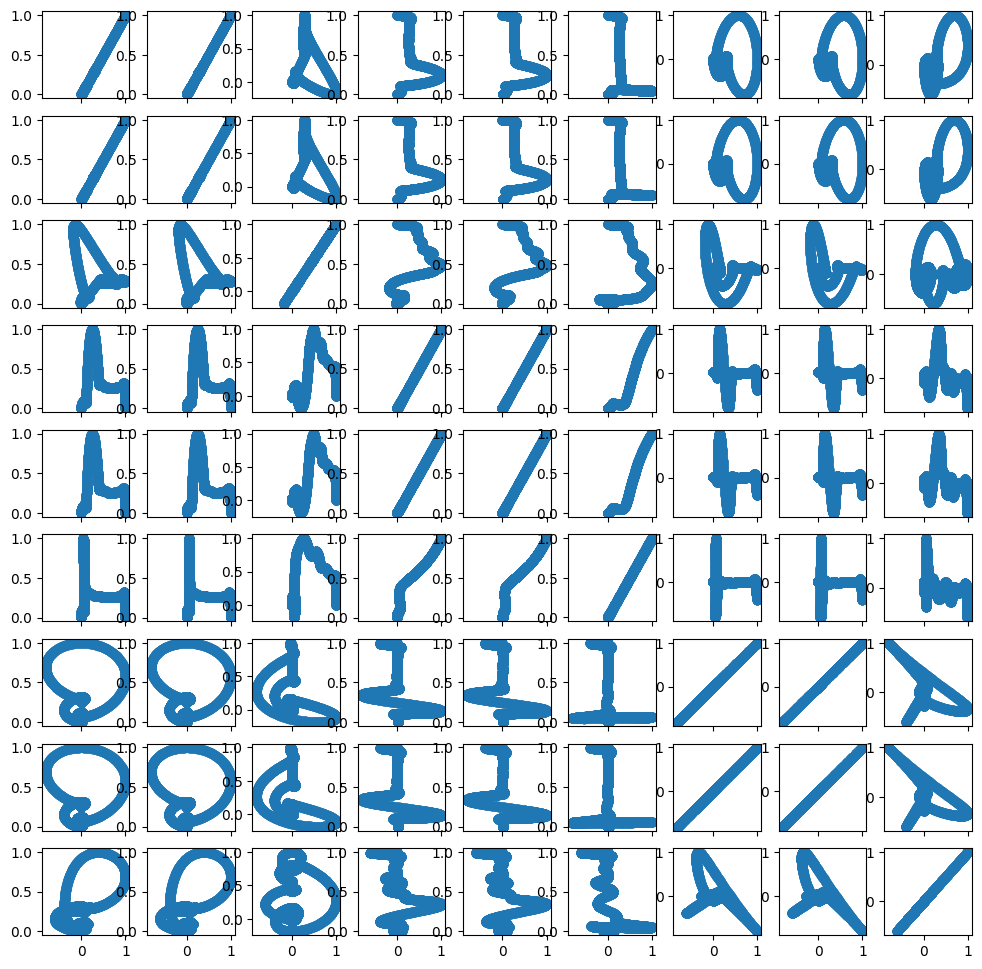

In [470]:
def __makeplot(st0):

    import matplotlib.pyplot as plt

    Nrow, Ncol = len(st0), len(st0)

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 12), sharex=True)

    # plt.subplots_adjust(hspace=0.1)

    for i in range(Nrow):
        for j in range(Ncol):
            ax[i, j].scatter(st0[i].data/max(st0[i].data), st0[j].data/max(st0[j].data))

#     ax.set_xscale("log")

#     ax.set_ylim(0, 8000)

    # ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    plt.show();
    return fig

fig = __makeplot(stx);

In [377]:
ttt = st[1].times()
arr = st[1].data
dt  = st[1].stats.delta # seconds

# out = __compute_cwt(ttt, arr, dt, tscale="hour", datalabel="Air Pressure (hPa)",
#                     log=False, period=True, fmax=None, plot=True)

# out['fig'].savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_CWT_2.png", format="png", dpi=200, bbox_inches='tight')


NameError: name 'st' is not defined

ValueError: zero-size array to reduction operation minimum which has no identity

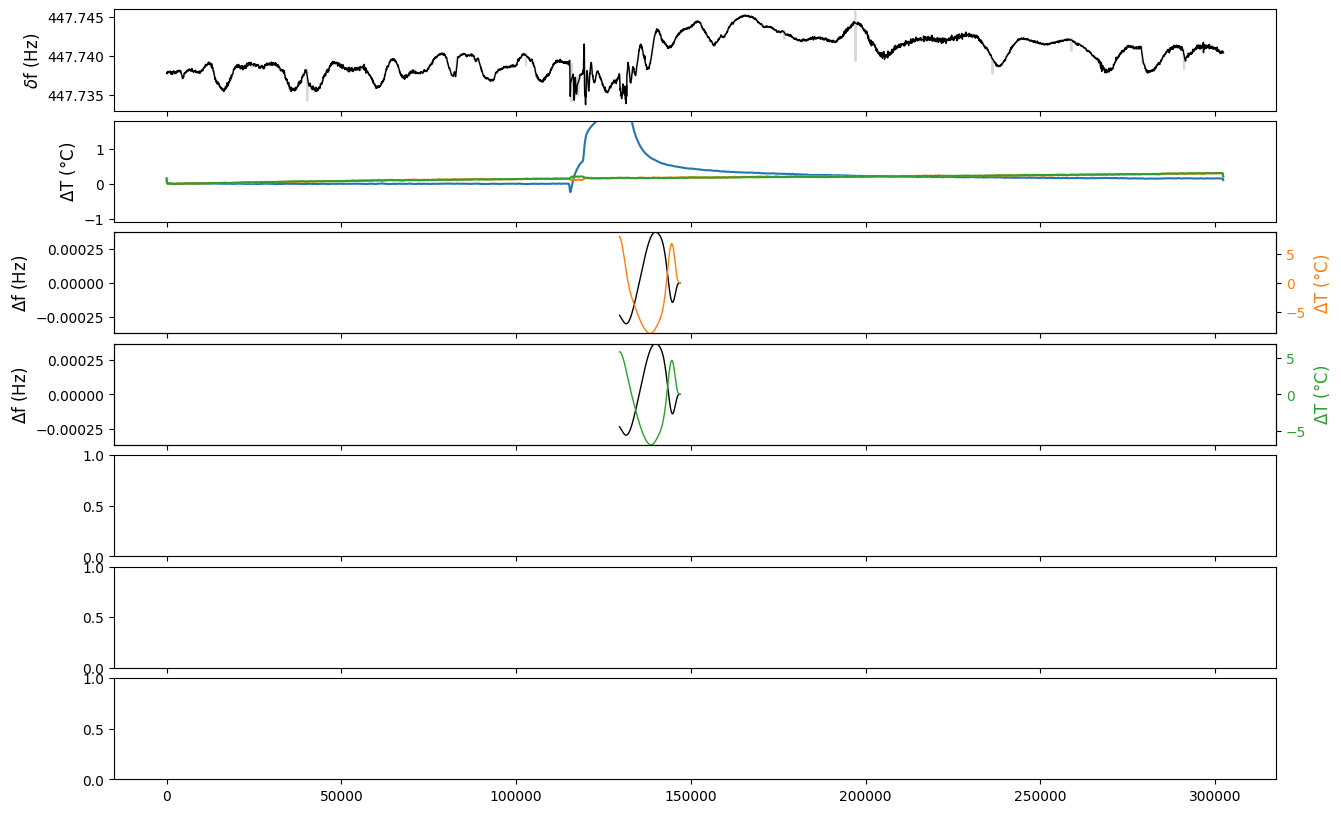

In [395]:
def __makeplot():

    from numpy import nanmax

    fl, fu = 1/(36*3600), 1/(1*3600)

    sta1 = "ROMY"
    loc2 = "09"

    lp = stt.copy()

    lp = lp.detrend("simple")
    lp = lp.taper(0.1)
    lp = lp.filter("bandpass", freqmin=fl, freqmax=fu, corners=4, zerophase=True)

    env0 = abs(hilbert(lp.select(station=sta1)[0].data))
    env1 = abs(hilbert(lp.select(location=loc2)[0].data))

    env0_smooth = __smooth(env0, 1)
    env1_smooth = __smooth(env1, 1)

    dt = stt[0].stats.delta
    over = 0.9
    twin = 1/fl ## seconds

    # tt, cc = __cross_correlation_windows(st.select(station=sta1)[0].data, st.select(location=loc2)[0].data, dt, twin, overlap=over, demean=True)
    tt_lp_05, cc_lp_05 = __cross_correlation_windows(lp.select(station=sta1)[0].data, lp.select(location="07")[0].data, dt, twin, overlap=over, demean=False)
    tt_lp_09, cc_lp_09 = __cross_correlation_windows(lp.select(station=sta1)[0].data, lp.select(location="09")[0].data, dt, twin, overlap=over, demean=False)


    Nrow, Ncol = 7, 1

    font = 12

    ref_date = str(bs.time1.iloc[0])[:10]

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1

    ax[0].plot(bs.time_sec, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(bs.time_sec, bs.fj_fs_inter, color="black", label="cleaned", lw=1)
    # ax[0].plot(bs.time_sec, bs.fj_fs_smooth, color="darkgrey", label=f"mov. avg. ({n_minutes} min)")
    # ax[0].plot(bs.time_sec, __smooth(bs.fj_fs_inter, 720), color="darkred", label=f"mov. avg. ({720} min)")
    ax[0].set_ylim(flim1, flim2)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\delta$f (Hz)", fontsize=font)


    ax[1].plot(ps.select(station="PROMY", location="01")[0].times(reftime=UTCDateTime(ref_date)),
               __reduce(ps.select(station="PROMY", location="01")[0].data, 100), color="tab:blue", label="PS1")
    ax[1].plot(ps.select(station="PROMY", location="07")[0].times(reftime=UTCDateTime(ref_date)),
               __reduce(ps.select(station="PROMY", location="07")[0].data, 100), color="tab:orange", label="PS7")
    ax[1].plot(ps.select(station="PROMY", location="09")[0].times(reftime=UTCDateTime(ref_date)),
               __reduce(ps.select(station="PROMY", location="09")[0].data, 100), color="tab:green", label="PS9")
    # ax[1].plot(ps.select(station="WROMY", location="01")[0].times(reftime=UTCDateTime(ref_date)),
    #            __reduce(ps.select(station="WROMY", location="01")[0].data, 100), color="tab:purple", label="WS1")
    ax[1].set_ylabel("$\Delta$T (°C)", fontsize=font)
    # [t.set_color('tab:purple') for t in ax00.yaxis.get_ticklabels()]
    ax[1].set_ylim(-1.1, 1.8)

    ax[2].plot(lp.select(station=sta1)[0].times(reftime=UTCDateTime(ref_date)),
               lp.select(station=sta1)[0].data, color="k", label=f"$\Delta$f ( bp = {round(1/fu/3600, 1)} - {round(1/fl/3600,1)} hr )", lw=1)


    ax11 = ax[2].twinx()
    ax11.plot(lp.select(location="07")[0].times(reftime=UTCDateTime(ref_date)),
              lp.select(location="07")[0].data, color="tab:orange", label="PS7", lw=1)
    ax11.set_ylabel("$\Delta$T (°C)", fontsize=font, color="tab:orange")
    [t.set_color('tab:orange') for t in ax11.yaxis.get_ticklabels()]


    max_lim = max([abs(min(lp.select(station=sta1)[0].data)), abs(max(lp.select(station=sta1)[0].data))])
    ax[2].set_ylim(-max_lim, max_lim)

    max_lim = max([abs(min(lp.select(location="07")[0].data)), abs(max(lp.select(location="07")[0].data))])
    ax11.set_ylim(-max_lim, max_lim)

    ax[2].set_ylabel("$\Delta$f (Hz)", fontsize=font)


    ax[3].plot(lp.select(station=sta1)[0].times(reftime=UTCDateTime(ref_date)),
               lp.select(station=sta1)[0].data, color="k", label=f"$\Delta$f ( bp = {round(1/fu/3600, 1)} - {round(1/fl/3600,1)} hr )", lw=1)

    ax33 = ax[3].twinx()
    ax33.plot(lp.select(location="09")[0].times(reftime=UTCDateTime(ref_date)),
              lp.select(location="09")[0].data, color="tab:green", label="PS9", lw=1)
    ax33.set_ylabel("$\Delta$T (°C)", fontsize=font, color="tab:green")
    [t.set_color('tab:green') for t in ax33.yaxis.get_ticklabels()]

    max_lim = max([abs(min(lp.select(station=sta1)[0].data)), abs(max(lp.select(station=sta1)[0].data))])
    ax[3].set_ylim(-max_lim, max_lim)

    max_lim = max([abs(min(lp.select(location="09")[0].data)), abs(max(lp.select(location="09")[0].data))])
    ax33.set_ylim(-max_lim, max_lim)

    ax[3].set_ylabel("$\Delta$f (Hz)", fontsize=font)


    ax[4].scatter(tt_lp_05, cc_lp_05, alpha=abs(cc_lp_05), label="CC (bandpass)", color="w", edgecolor="tab:orange", lw=1.5, zorder=2)
    ax[4].scatter(tt_lp_09, cc_lp_09, alpha=abs(cc_lp_09), label="CC (bandpass)", color="w", edgecolor="tab:green", lw=1.5, zorder=2)
    ax[4].set_ylim(-1.1, 1.1)
    ax[4].set_ylabel("Zero-Lag \nCC-Coeff.", fontsize=font)



    ttt, ccf, tlags, shifts, maxima = __cross_correlation_function_windows(lp.select(location="05")[0].data,
                                                                           lp.select(station=sta1)[0].data,
                                                                           dt, twin, overlap=0.5, demean=True,
                                                                          )
    cmap = plt.get_cmap("coolwarm")
    ca5 = ax[5].pcolormesh(ttt, tlags/60, ccf.T, rasterized=True, vmin=-1, vmax=1, cmap=cmap)
    ax[5].set_ylabel("Lag (min)", fontsize=font)
    ax[5].text(.96, .96, 'PS5', ha='left', va='top', transform=ax[5].transAxes, fontsize=font)


    ttt, ccf, tlags, shifts, maxima = __cross_correlation_function_windows(lp.select(location="09")[0].data,
                                                                           lp.select(station=sta1)[0].data,
                                                                           dt, twin, overlap=0.5, demean=True,
                                                                          )
    cmap = plt.get_cmap("coolwarm") # cmap = plt.get_cmap("PuOr")
    ca6 = ax[6].pcolormesh(ttt, tlags/60, ccf.T, rasterized=True, vmin=-1, vmax=1, cmap=cmap)
    ax[6].set_ylabel("Lag (min)", fontsize=font)
    ax[6].text(.96, .96, 'PS9', ha='left', va='top', transform=ax[6].transAxes, fontsize=font)


    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].set_xlim(left=0)

    ax[0].legend(loc=1, ncol=3)
    ax[1].legend(loc=4, ncol=1)
    ax[2].legend(loc=1, ncol=3)
    ax[3].legend(loc=4, ncol=3)
    # ax[4].legend(loc=4, ncol=3)

    ## add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    ## add labels for subplots
    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)', '(e)', '(f)','(g)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)


    ## add colorbar
    cbar_ax = fig.add_axes([0.91, 0.22, 0.02, 0.1]) #[left, bottom, width, height]
    cb = plt.colorbar(ca5, cax=cbar_ax)
    cb.set_label("CC", fontsize=font, labelpad=-1, color="black")

    cbar_ax = fig.add_axes([0.91, 0.11, 0.02, 0.1]) #[left, bottom, width, height]
    cb = plt.colorbar(ca6, cax=cbar_ax)
    cb.set_label("CC", fontsize=font, labelpad=-1, color="black")

    gc.collect()

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_Case{case}_temperature.png", format="png", dpi=150, bbox_inches='tight')


In [1]:
tr00 = Trace()
tr00.data = np.array(bs.w_s_inter)
tr00.stats.delta = 60
tr00.stats.starttime = bs.time1.iloc[0]
tr00.stats.network = "BW"
tr00.stats.station = "ROMY"
tr00.stats.location = "U"

tr01 = Trace()
tr01.data = np.array(bs.w_s)
tr01.stats.delta = 60
tr01.stats.starttime = bs.time1.iloc[0]
tr01.stats.network = "BW"
tr01.stats.station = "ROMY"
tr01.stats.location = "UR"

st_all = Stream()
st_all += tr00.copy()
st_all += tr01.copy()
st_all += ps.copy()

print(st_all)

st_all.resample(0.01)

st_all.plot(equal_scale=False);

NameError: name 'Trace' is not defined

/tmp/ipykernel_978418/884577368.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(tcklbls)
/tmp/ipykernel_978418/884577368.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(tcklbls)


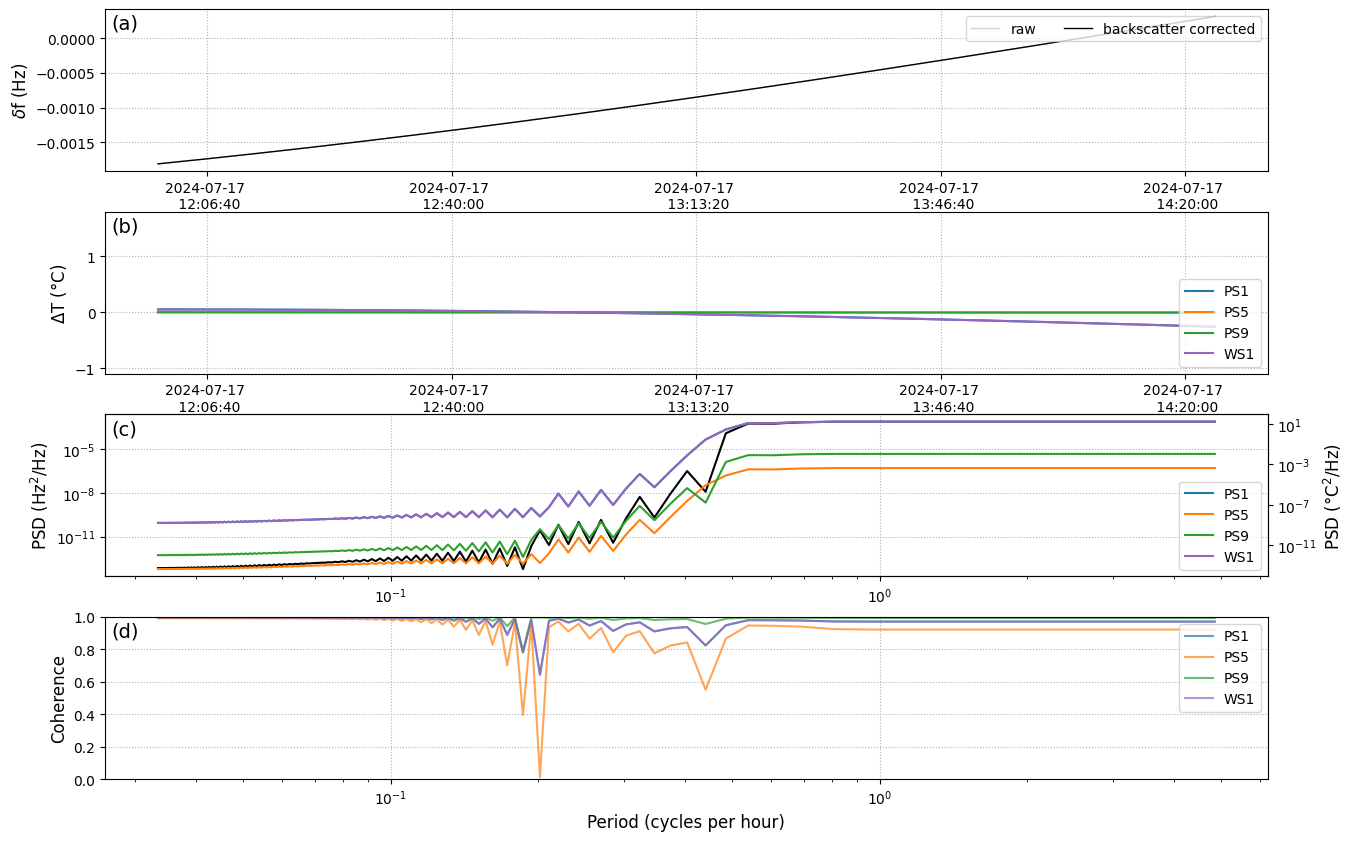

In [697]:
def __makeplot(st0):


    dat0 = st0.select(station="ROMY")[0].data

    dat1 = st0.select(station="PROMY", location="01")[0].data
    dat2 = st0.select(station="PROMY", location="07")[0].data
    dat3 = st0.select(station="PROMY", location="09")[0].data
    dat4 = st0.select(station="PROMY", location="01")[0].data

    dt, df = st0[0].stats.delta, st0[0].stats.sampling_rate

    out01 = __multitaper_coherence(dat0, dat1, dt, n_taper=20, time_bandwidth=3.5, method=0)
    out02 = __multitaper_coherence(dat0, dat2, dt, n_taper=20, time_bandwidth=3.5, method=0)
    out03 = __multitaper_coherence(dat0, dat3, dt, n_taper=20, time_bandwidth=3.5, method=0)
    out04 = __multitaper_coherence(dat0, dat4, dt, n_taper=20, time_bandwidth=3.5, method=0)


    # f1, psd1, pha1 = __get_fft(dat1, df)
    # f2, psd2, pha2 = __get_fft(dat2, df)


    Nrow, Ncol = 4, 1

    font = 12

    ref_date = config['tbeg'].date

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=False)

    plt.subplots_adjust(hspace=0.25)

    # time_scaling = 1/86400
    time_scaling = 1

    ax[0].plot(st0.select(station="ROMY", location="")[0].times(reftime=UTCDateTime(ref_date)),
               st0.select(station="ROMY", location="")[0].data, color="lightgrey", label="raw", lw=1)
    ax[0].plot(st0.select(station="ROMY", location="")[0].times(reftime=UTCDateTime(ref_date)),
               st0.select(station="ROMY", location="")[0].data, color="black", label="backscatter corrected", lw=1)


    # ax[0].set_ylim(flim1, flim2)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\delta$f (Hz)", fontsize=font)


    ax[1].plot(st0.select(station="PROMY", location="01")[0].times(reftime=UTCDateTime(ref_date)),
               __reduce(st0.select(station="PROMY", location="01")[0].data, 100), color="tab:blue", label="PS1")
    ax[1].plot(st0.select(station="PROMY", location="07")[0].times(reftime=UTCDateTime(ref_date)),
               __reduce(st0.select(station="PROMY", location="07")[0].data, 100), color="tab:orange", label="PS5")
    ax[1].plot(st0.select(station="PROMY", location="09")[0].times(reftime=UTCDateTime(ref_date)),
               __reduce(st0.select(station="PROMY", location="09")[0].data, 100), color="tab:green", label="PS9")

    ax[1].plot(st0.select(station="PROMY", location="01")[0].times(reftime=UTCDateTime(ref_date)),
               __reduce(st0.select(station="PROMY", location="01")[0].data, 100), color="tab:purple", label="WS1")

    ax[1].set_ylabel("$\Delta$T (°C)", fontsize=font)
    # [t.set_color('tab:purple') for t in ax00.yaxis.get_ticklabels()]

    ax[1].set_ylim(-1.1, 1.8)

    ax[2].plot(1/out01['ff1'][1:]/3600, out01['psd1'][1:], color="k")
    ax[2].set_xscale("log")
    ax[2].set_yscale("log")
    ax[2].set_ylabel(f"PSD (Hz$^2$/Hz)", fontsize=font)


    ax22 = ax[2].twinx()
    ax22.plot(1/out01['ff2'][1:]/3600, out01['psd2'][1:], color="tab:blue", label="PS1")
    ax22.plot(1/out02['ff2'][1:]/3600, out02['psd2'][1:], color="tab:orange", label="PS5")
    ax22.plot(1/out03['ff2'][1:]/3600, out03['psd2'][1:], color="tab:green", label="PS9")
    ax22.plot(1/out04['ff2'][1:]/3600, out04['psd2'][1:], color="tab:purple", label="WS1")
    ax22.set_xscale("log")
    ax22.set_yscale("log")
    ax22.set_ylabel(f"PSD (°C$^2$/Hz)", fontsize=font)

    ax[3].plot(1/out01['fcoh'][1:]/3600, out01['coh'][1:], alpha=0.7, color="tab:blue", label="PS1")
    ax[3].plot(1/out02['fcoh'][1:]/3600, out02['coh'][1:], alpha=0.7, color="tab:orange", label="PS5")
    ax[3].plot(1/out03['fcoh'][1:]/3600, out03['coh'][1:], alpha=0.7, color="tab:green", label="PS9")
    ax[3].plot(1/out04['fcoh'][1:]/3600, out04['coh'][1:], alpha=0.7, color="tab:purple", label="WS1")
    ax[3].set_xscale("log")
    ax[3].set_ylabel("Coherence", fontsize=font)
    ax[3].set_xlabel("Period (cycles per hour)", fontsize=font)
    ax[3].set_ylim(0, 1)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        # ax[_n].set_xlim(left=0)

    ax[0].legend(loc=1, ncol=3)
    ax[1].legend(loc=4, ncol=1)
    ax22.legend(loc=4, ncol=1)
    ax[3].legend(loc=1, ncol=1)


    ## add dates to x-axis
    tcks = ax[0].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[0].set_xticklabels(tcklbls)
    tcks = ax[1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[1].set_xticklabels(tcklbls)

    ## add labels for subplots
    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)


    gc.collect()

    plt.show();
    return fig

fig = __makeplot(stt)

fig.savefig(config['path_to_figs']+f"SF_BS_RU_Case{case}_spectra_temperature.png", format="png", dpi=150, bbox_inches='tight')
